In [21]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
%matplotlib inline

from collections import Counter

In [22]:
# Load training and test sets (assumes you have these in current working directory)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [23]:
# Inspect training set
train.head()

,Id,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,...,Feat 243,Feat 244,Feat 245,Feat 246,Feat 247,Feat 248,Feat 249,Feat 250,Feat 251,Target
0,1,0.998952,0.174118,0.999211,0.996460,0.133333,0.057143,0.000,0.0,0.0,...,0.0,0.0,0,0.612863,0.026812,0.522,0.217791,0.233629,0.540962,0.901355
1,2,0.999445,0.174118,0.999329,0.997079,0.133333,0.000000,0.000,0.0,0.0,...,0.0,0.0,0,0.688941,0.075030,0.704,0.246119,0.143860,0.525384,0.913550
2,3,0.998759,0.000000,0.997260,0.996325,0.000000,0.085714,0.125,0.0,0.0,...,0.0,0.0,0,0.156863,0.436279,0.000,0.119091,0.162869,0.361124,0.884824
3,4,0.999619,0.174118,0.997969,0.997321,0.266667,0.057143,0.125,0.0,0.0,...,0.0,0.0,0,0.709647,0.075472,0.513,0.392743,0.377302,0.613776,0.977236
4,5,0.998278,0.174118,0.998427,0.996269,0.200000,0.000000,0.000,0.0,0.0,...,0.0,0.0,0,0.364235,0.041818,0.200,0.096297,0.166459,0.408322,0.921138


In [24]:
# Inspect test set
test.head()

,Id,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,...,Feat 242,Feat 243,Feat 244,Feat 245,Feat 246,Feat 247,Feat 248,Feat 249,Feat 250,Feat 251
0,1,0.999849,0.174118,0.999819,0.997841,0.133333,0.2,0.0,0.0,0.000000,...,0.0,0.0,0.0,0,0.728471,0.054397,0.649,0.416164,0.053998,0.667391
1,2,0.999958,0.164706,1.000000,0.996741,0.066667,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0,0.497255,0.037736,0.375,0.165514,0.101973,0.506650
2,3,0.999666,0.174118,0.999479,0.997376,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0,0.688941,0.019309,1.000,0.192069,0.120700,0.498784
3,4,0.999735,0.174118,0.999655,0.997173,0.133333,0.0,0.0,0.0,0.363636,...,0.0,0.0,0.0,0,0.654118,0.019089,0.333,0.451252,0.164180,0.774466
4,5,0.999806,0.164706,0.999551,0.997234,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0,0.627451,0.160433,0.882,0.147407,0.000000,0.481240


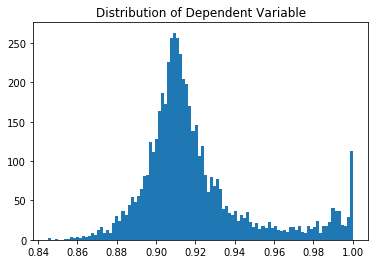

In [25]:
# Explore distribution of target
plt.hist(train['Target'], bins = 100)
plt.title("Distribution of Dependent Variable")
plt.show()

In [26]:
# Split training set into X and y (removing first column containing IDs)
X_train = train.iloc[:, 1:-1]
y_train = train.iloc[:, -1]

In [27]:
# Define function to compute RMSE
def scoreRMSE(predictor, X, true_y):
    predictions = predictor.predict(X)
    return np.sqrt(mean_squared_error(predictions, true_y))

In [28]:
# Define function to return labels of features not meeting a certain threshold
def get_bad_features(df, thresh):
    means = df.mean()
    bads = []
    for label, mean in means.iteritems():
        if mean < thresh:
            bads += [label]
    return bads

In [29]:
# Remove bad features
bad_features = get_bad_features(X_train, 0.001)
X_train = X_train.drop(columns=bad_features)

In [30]:
# Fit unregularized linear regression and see RMSE on training set
linReg = Lin_Reg()
linReg.fit(X_train, y_train)

print("Training RMSE: ", scoreRMSE(linReg, X_train, y_train))

Training RMSE:  0.026472707119020892


In [31]:
# Remove first column to make predictions
X_test = test.iloc[:, 1:]
X_test = X_test.drop(columns=bad_features)
X_test.head()

,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,Feat 10,...,Feat 235,Feat 241,Feat 242,Feat 243,Feat 246,Feat 247,Feat 248,Feat 249,Feat 250,Feat 251
0,0.999849,0.174118,0.999819,0.997841,0.133333,0.2,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.728471,0.054397,0.649,0.416164,0.053998,0.667391
1,0.999958,0.164706,1.000000,0.996741,0.066667,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.497255,0.037736,0.375,0.165514,0.101973,0.506650
2,0.999666,0.174118,0.999479,0.997376,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.688941,0.019309,1.000,0.192069,0.120700,0.498784
3,0.999735,0.174118,0.999655,0.997173,0.133333,0.0,0.0,0.0,0.363636,0.166667,...,0.0,0.0,0.0,0.0,0.654118,0.019089,0.333,0.451252,0.164180,0.774466
4,0.999806,0.164706,0.999551,0.997234,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.627451,0.160433,0.882,0.147407,0.000000,0.481240


In [32]:
# Make predictions using linear regression model fitted above
predictions = linReg.predict(X_test)

In [33]:
# Format predictions to be compatible with Kaggle upload
sample_submission = pd.DataFrame(data=predictions, columns=['Predicted'])
sample_submission.insert(0, "Id", range(1, 1 + X_test.shape[0]))
sample_submission['Id'] = sample_submission['Id'].astype(str)
sample_submission.head()

,Id,Predicted
0,1,0.935405
1,2,0.914841
2,3,0.921369
3,4,0.933464
4,5,0.925662


In [34]:
# Save predictions to .csv file for upload to Kaggle
sample_submission.to_csv("submission1.csv", index=False)

In [38]:
# Random Forest Regression Model

print("performing grid search")
# Perform Grid-Search
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(3,7),
        'n_estimators': (10, 50, 100, 1000),
    },
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
print("grid result")
grid_result = gsc.fit(X_train, y_train)


performing grid search
grid result
rfr


NameError: name 'best_params' is not defined